In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Пред обработка

Загрузим датасет из файла

In [3]:
df = pd.read_csv("bank_loan_default.csv")
df.info()
display(df.shape)
display(df.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3041 entries, 0 to 3040
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                3041 non-null   int64  
 1   annual_income      3041 non-null   float64
 2   employment_type    3041 non-null   object 
 3   education          3041 non-null   object 
 4   loan_amount        3041 non-null   float64
 5   interest_rate_pct  3041 non-null   float64
 6   term_months        3041 non-null   int64  
 7   credit_score       3041 non-null   float64
 8   num_open_accounts  3041 non-null   int64  
 9   delinquency_30d    3041 non-null   object 
 10  residence_type     3041 non-null   object 
 11  Default            3041 non-null   int64  
dtypes: float64(4), int64(4), object(4)
memory usage: 285.2+ KB


(3041, 12)

,age,annual_income,employment_type,education,loan_amount,interest_rate_pct,term_months,credit_score,num_open_accounts,delinquency_30d,residence_type,Default
0,42,57272.0,Self-Employed,Masters,8516.0,5.85,48,730.0,10,No,Own,0
1,51,45786.0,Salaried,Masters,13760.0,9.97,36,677.0,7,No,Mortgage,0
2,69,42359.0,Salaried,Bachelors,2569.0,13.75,48,624.0,2,No,Own,0
3,65,50709.0,Self-Employed,Masters,13204.0,8.70,48,698.0,3,No,Rent,0
4,30,46272.0,Salaried,HS,7700.0,7.53,48,532.0,7,No,Rent,0


Переименуем колонки, чтобы они придерживались единого стиля


In [4]:
df.columns = df.columns.str.lower()

Проверка на неявные дубликаты


In [5]:
print(str(df.employment_type.value_counts()))
print(str(df.education.value_counts()))
print(str(df.residence_type.value_counts()))
print(str(df.delinquency_30d.value_counts()))

employment_type
Salaried         2132
Self-Employed     682
Unemployed        227
Name: count, dtype: int64
education
Bachelors    1181
HS            956
Masters       748
PhD           156
Name: count, dtype: int64
residence_type
Rent        1241
Own         1065
Mortgage     735
Name: count, dtype: int64
delinquency_30d
No     2668
Yes     373
Name: count, dtype: int64


В результате пред обработки данных проверены категориальные типы данных, неявных дубликатов не найдено. Явных дубликатов не найдено.
Исправлено название одного из признаков.

Целевым признаком в данном датасете является `default` - дефолт по кредиту.

Для выявление закономерностей построена матрица диаграмм рассеивания


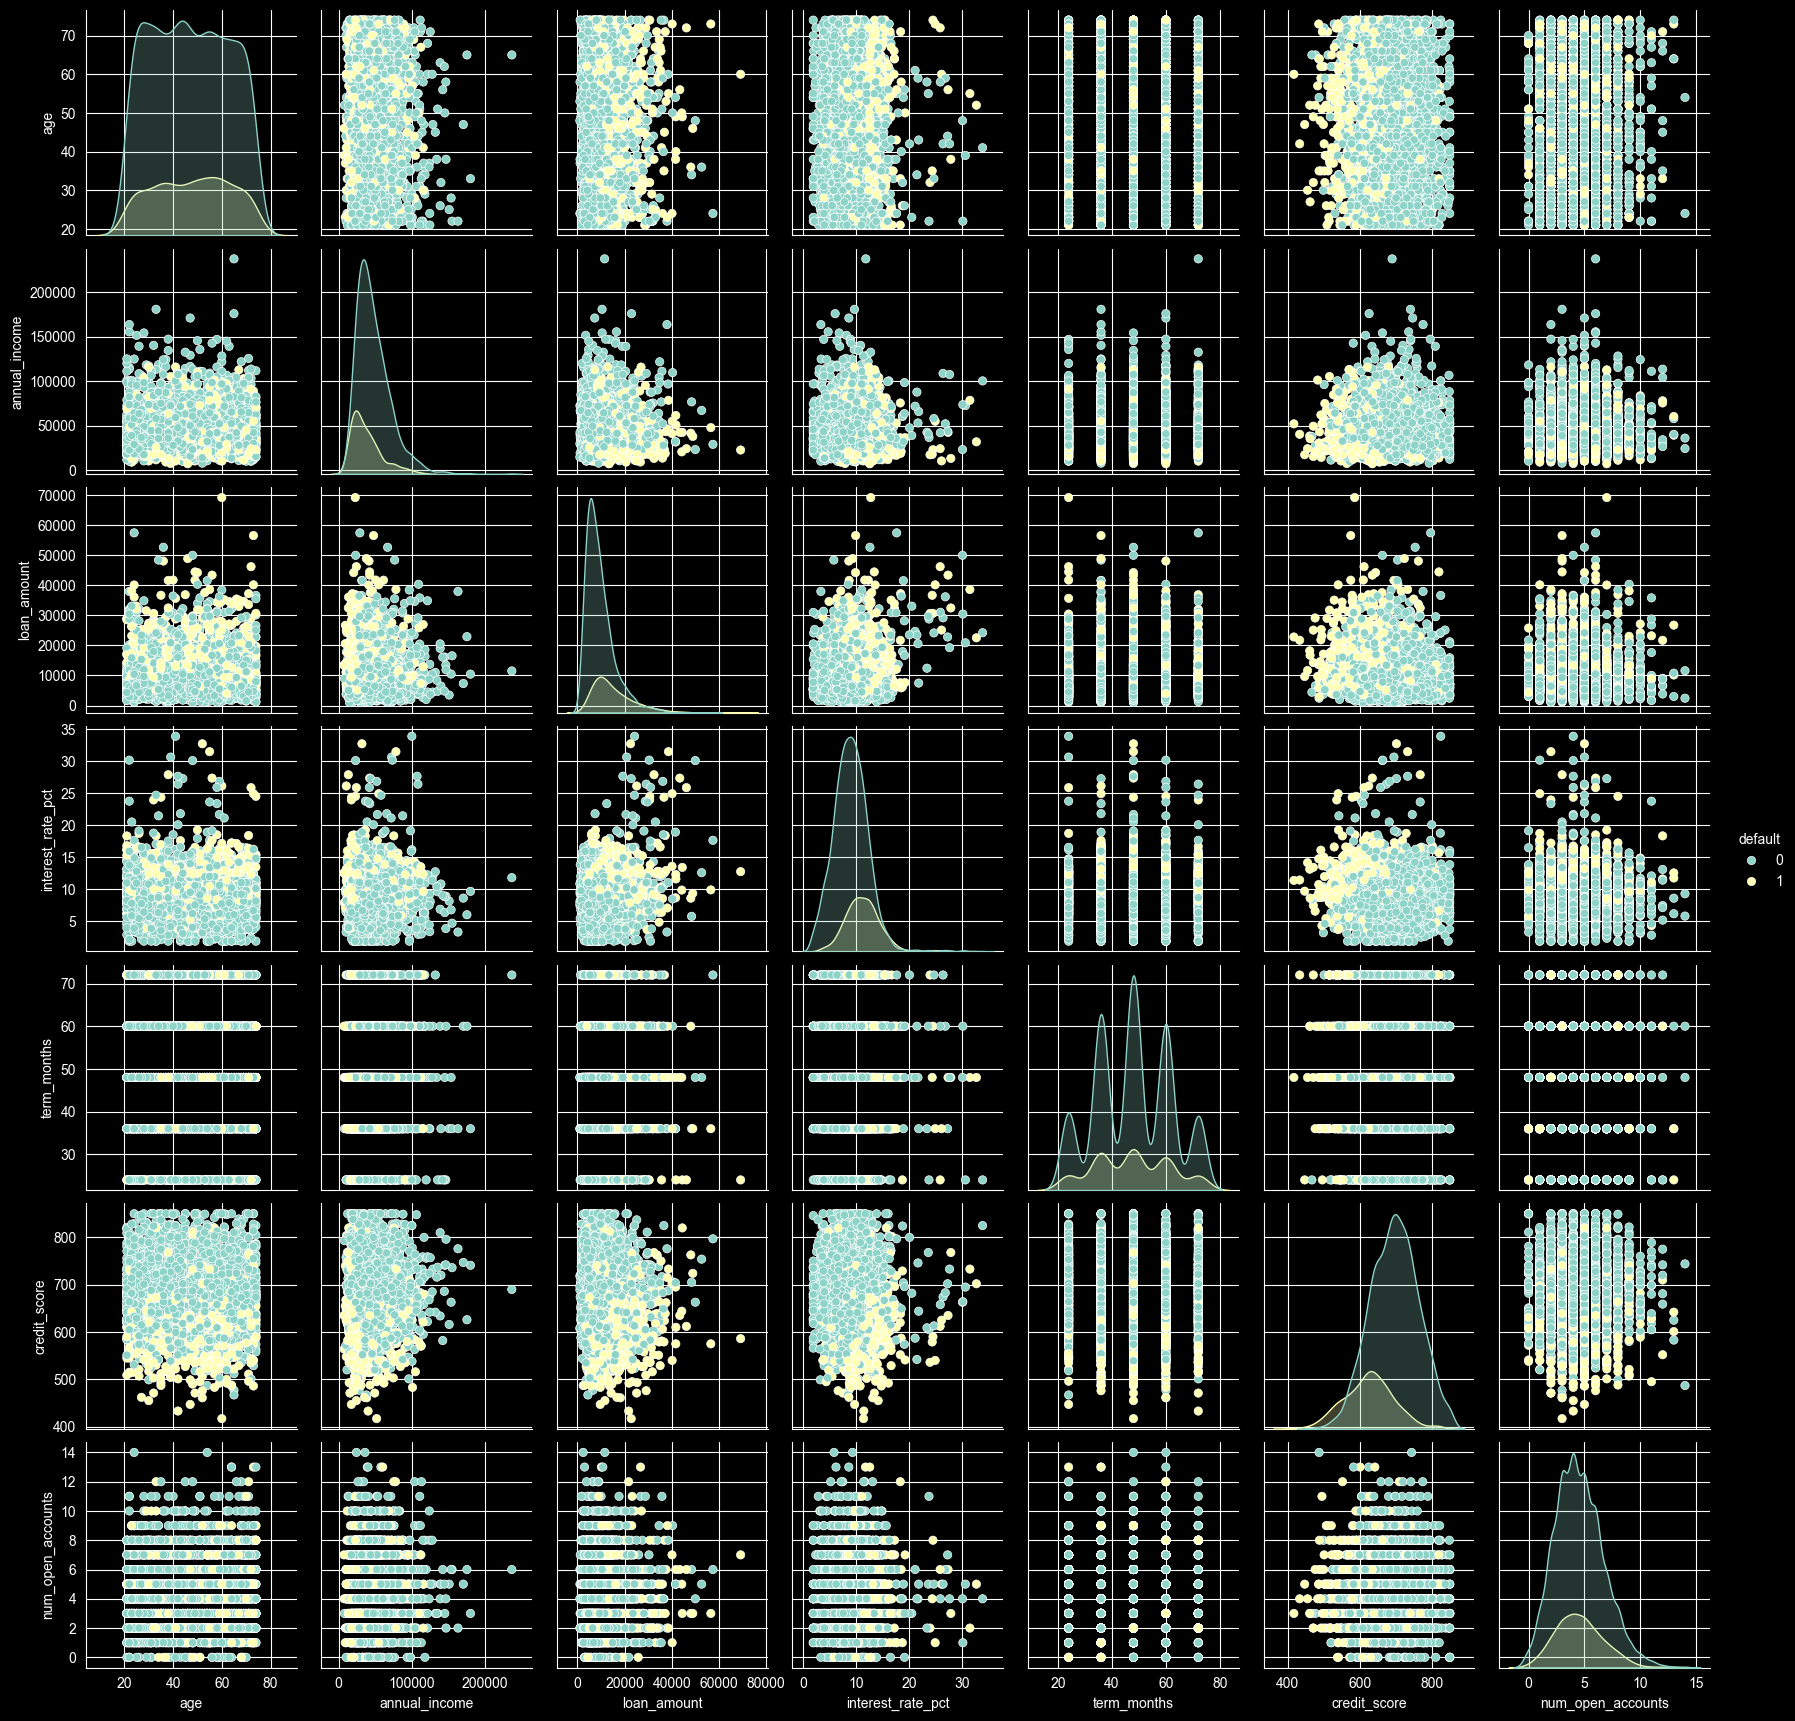

In [6]:
sns.pairplot(df, hue='default')

Визуально можно сделать следующие выводы:
- заемщики с меньшим процентом с меньшим шансом оказываются в дефолте
- чем выше кредитный счет, тем ниже шанс дефолта
- чем выше доход, тем ниже шанс дефолта

Возможно, более сложные зависимости не заметны визуально.

Выполним кодирование категориальных типов данных методом OrdinalEncoding

In [7]:
from sklearn.preprocessing import OrdinalEncoder
oe = OrdinalEncoder()

df_src = df.copy()

for col in df.select_dtypes(include='object').columns:
    df[col] = oe.fit_transform(pd.DataFrame(df[col]))

Выполним стандартизацию числовых данных методом StandardScaler

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

y = df.default
X = df.drop('default', axis=1)
X = scaler.fit_transform(X)

Разделим на тренировочную и тестовую выборки

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0
)

# Обучение моделей

Обучим четыре модели: 
- Дерево решений
- k-Ближайших соседей
- Случайный лес
- Логистическая регрессия

Сравним метрики каждой из них

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, balanced_accuracy_score, f1_score, \
    confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

models = {
    'метод k-ближайших соседей': KNeighborsClassifier(n_neighbors=5),
    'дерево решений': DecisionTreeClassifier(max_depth=5, random_state=42, class_weight='balanced'),
    'логистическая регрессия': LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    'случайный лес': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
}

metrics = {
    # 'Confusion Matrix': confusion_matrix,
    'Accuracy': accuracy_score,
    'Precision': precision_score,
    'Recall': recall_score,
    'Balanced Accuracy': balanced_accuracy_score,
    'F1 Score': f1_score
}

metric_scores = {}
predictions = {}
probabilities = {}

for name, model in models.items():
    print()
    print(name)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)

    predictions[name] = y_pred
    probabilities[name] = y_prob

    scores = {label: fn(y_test, y_pred) for label, fn in metrics.items()}
    metric_scores[name] = scores

    for label, value in scores.items():
        print(f"{label} = {value:.4f}")

    metric_scores[name]["confusion"] = confusion_matrix(y_test, y_pred)
    print(metric_scores[name]["confusion"])



метод k-ближайших соседей
Accuracy = 0.8237
Precision = 0.6636
Recall = 0.3622
Balanced Accuracy = 0.6560
F1 Score = 0.4686
[[681  36]
 [125  71]]

дерево решений
Accuracy = 0.7886
Precision = 0.5060
Recall = 0.6429
Balanced Accuracy = 0.7357
F1 Score = 0.5663
[[594 123]
 [ 70 126]]

логистическая регрессия
Accuracy = 0.7788
Precision = 0.4903
Recall = 0.7755
Balanced Accuracy = 0.7776
F1 Score = 0.6008
[[559 158]
 [ 44 152]]

случайный лес
Accuracy = 0.8467
Precision = 0.7373
Recall = 0.4439
Balanced Accuracy = 0.7003
F1 Score = 0.5541
[[686  31]
 [109  87]]


Выбор модели в данном случае зависит от требований бизнеса, так как есть несколько хороших кандидатов со своими плюсами и минусами.

Если приоритет - выявить как можно больше дефолтов (минимум FN), то лучше подходит логистическая регрессия: лучший recall, лучший F1 и сбалансированная точность.

Если приоритет - сократить ошибочные отказы (минимум FP), то лучше подходит случайный лес: лучший precision и точность.

Визуализируем полученные матрицы неточностей

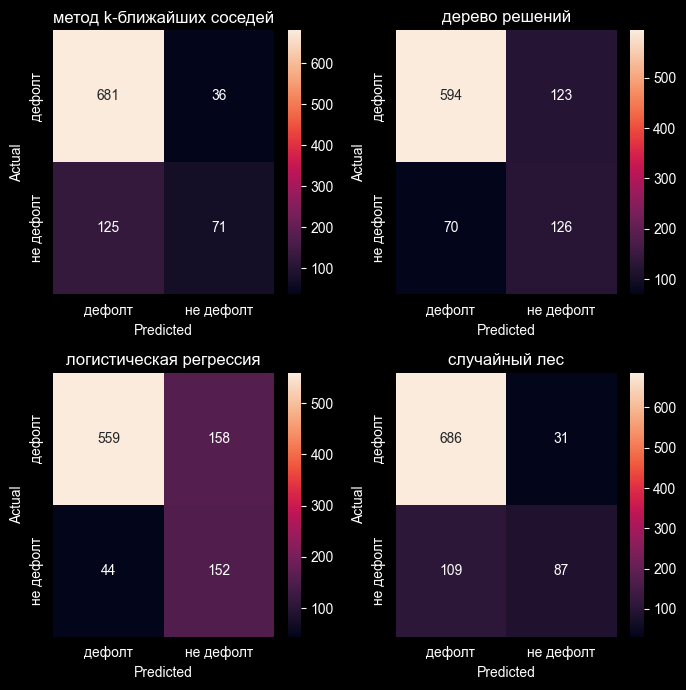

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(7, 7))
axes = axes.flatten()

for idx, name in enumerate(predictions.keys()):
    sns.heatmap(metric_scores[name]["confusion"], annot=True, fmt='d',
                xticklabels=['дефолт', 'не дефолт'],
                yticklabels=['дефолт', 'не дефолт'],
                ax=axes[idx])

    axes[idx].set_title(f'{name}')
    axes[idx].set_ylabel('Actual')
    axes[idx].set_xlabel('Predicted')

plt.tight_layout()
plt.show()

Выбор модели зависит от задачи бизнеса: минимизировать FN - логистическая регрессия; минимизировать FP - случайный лес; нужен баланс - дерево решений.

В целом, логичтическая регрессия показывает наиболее сбалансированные результаты - не такая чувтствительная, как дерево решений, и более чувствителная по сравнению с методом ближайших соседей и случайным лесом

Построим ROC-кривые для визуализации качества классификации

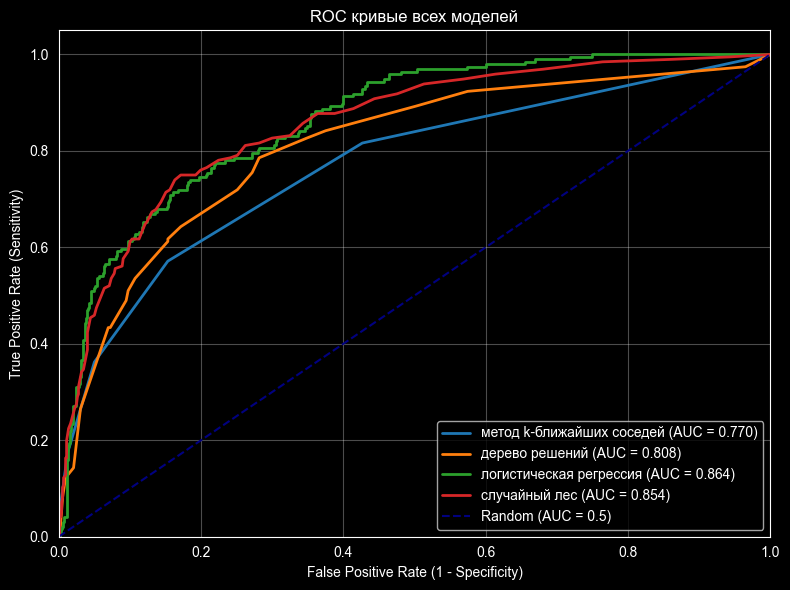

In [12]:
# python
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 6))
colors = plt.cm.tab10.colors

for idx, (name, y_prob) in enumerate(probabilities.items()):
    fpr, tpr, _ = roc_curve(y_test,  y_prob[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, color=colors[idx % len(colors)],
             label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--', label='Random (AUC = 0.5)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC кривые всех моделей')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Все модели показывают себя значительно лучше случайного угадывания.

Лучшего всего себя показывает логистическая кривая с AUC = 0.864, что что свидетельствует о хорошей дискриминационной способности модели.

Случайный лес близок с AUC = 0.854, однако на всем диапазоне уступает логистической кривой.

Метод k-ближайших соседей самый слабый с AUC = 0.770, но даже он показывает хороший результат.

# Вывод

В ходе выполнения лабораторной работы были изучены алгоритмы и методы классификации, получены навыки их практического применения на реальных данных.

На основании реального датасета с данными о кредитах построены рабочие модели, предсказывающие, сможет ли криент выплатить кредит. Были построены модели четырьмя алгоритмами классификации: метод k-ближайших соседей, дерево решений, логистическая регрессия и случайный лес.

Анализ моделей по метрикам f-score, precision, recall и confusion matrix показал, что все из моделей справляются с задачей хорошо. Однако, наилучшая модель зависит от требований бизнеса.

Если приоритет - выявить как можно больше дефолтов (минимум FN), то лучше подходит логистическая регрессия: лучший recall, лучший F1 и сбалансированная точность.

Если приоритет - сократить ошибочные отказы (минимум FP), то лучше подходит случайный лес: лучший precision и точность.


# Доп задания

## Задание 10
Осуществить подбор оптимальных параметров с помощью GridSearchCV для случайного леса. Сравнить качество модели для подобранных параметров и любых других.

In [13]:
from sklearn.model_selection import GridSearchCV

# Параметры для подбора
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


rf = RandomForestClassifier(random_state=42)

# параметры поиска
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    n_jobs=1,
    verbose=1,
    scoring='f1'
)

# поиск
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# базовый лес
default_rf = RandomForestClassifier(n_estimators=100, random_state=42)
default_rf.fit(X_train, y_train)

# предсказать
y_pred_tuned = best_model.predict(X_test)
y_pred_default = default_rf.predict(X_test)

# сравнить
metrics = {
    'Accuracy': [accuracy_score(y_test, y_pred_default), accuracy_score(y_test, y_pred_tuned)],
    'Precision': [precision_score(y_test, y_pred_default, average='weighted'), precision_score(y_test, y_pred_tuned, average='weighted')],
    'Recall': [recall_score(y_test, y_pred_default, average='weighted'), recall_score(y_test, y_pred_tuned, average='weighted')],
    'F1-Score': [f1_score(y_test, y_pred_default, average='weighted'), f1_score(y_test, y_pred_tuned, average='weighted')]
}

comparison_df = pd.DataFrame(metrics, index=['Обычая модель', 'Tuned модель']).T
print(comparison_df)
print(f"\nОптимальные параметры: {best_params}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits
           Обычая модель  Tuned модель
Accuracy        0.852136      0.845564
Precision       0.842219      0.834251
Recall          0.852136      0.845564
F1-Score        0.840646      0.832128

Оптимальные параметры: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}


Базовая модель практически равна tunned, тк различие в метриках составляет около 0.005, почти случайность. Случайный лес с параметрами по умолчанию оказался уже вполне подходящим к задаче, поэтому GridSearchCV улучшил параметры. Найденные оптимальные параметры не дают ощутимого прироста качества модели

## Задание 15
Написать программу, которая для случайного для разного параметра n_estimators будет считать accuracy_score для тренировочных и тестовых данных (использовать predict на X_train и X_valid). Выполнить визуализацию: по оси х - значение параметра n_estimators, по оси y Accuracy, построить две линии для тренировочных и тестовых данных.

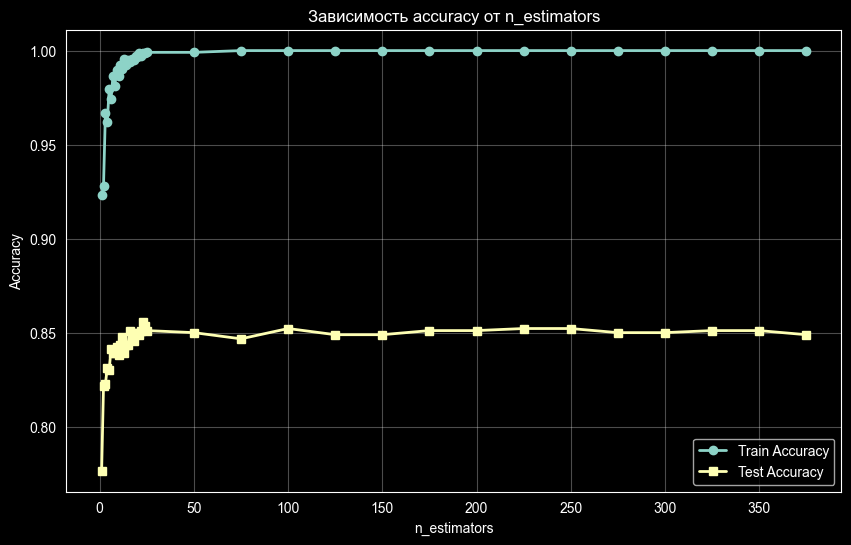

In [14]:
train_scores = []
test_scores = []

n_est = []

for n in list(range(1, 25, 1))+list(range(25,400 ,25 )):
    model = RandomForestClassifier(n_estimators=n, random_state=42)
    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)

    train_scores.append(train_accuracy)
    test_scores.append(test_accuracy)
    n_est.append(n)


plt.figure(figsize=(10, 6))
plt.plot(n_est, train_scores, label='Train Accuracy', marker='o', linewidth=2)
plt.plot(n_est, test_scores, label='Test Accuracy', marker='s', linewidth=2)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.title('Зависимость accuracy от n_estimators')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Accuracy быстро растет при малых параметрах (до 25-30), но затем достигает плано около 100. Увеличение количества n_estimators не дает роста accuracy. Тренировочная accuracy на 0.15 выше тестовой, что может указывать на переобучение модели. Уже при n_estimators=100 модель достигает баланса между accuracy и сложностью.

## Важность class_weight

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, balanced_accuracy_score, f1_score, \
    confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd

# Модели без class_weight
models_without = {
    'метод k-ближайших соседей': KNeighborsClassifier(n_neighbors=5),
    'дерево решений': DecisionTreeClassifier(max_depth=5, random_state=42),
    'логистическая регрессия': LogisticRegression(max_iter=1000, random_state=42),
    'случайный лес': RandomForestClassifier(n_estimators=100, random_state=42)
}

# Модели с class_weight='balanced'
models_with = {
    'метод k-ближайших соседей': KNeighborsClassifier(n_neighbors=5),
    'дерево решений': DecisionTreeClassifier(max_depth=5, random_state=42, class_weight='balanced'),
    'логистическая регрессия': LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    'случайный лес': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
}

metrics = {
    'Accuracy': accuracy_score,
    'Precision': precision_score,
    'Recall': recall_score,
    'Balanced Accuracy': balanced_accuracy_score,
    'F1 Score': f1_score
}

results = []

for variant_name, models in [('Без class_weight', models_without), ('С class_weight=balanced', models_with)]:

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        for label, fn in metrics.items():
            value = fn(y_test, y_pred)
            results.append({
                'Вариант': variant_name,
                'Модель': name,
                'Метрика': label,
                'Значение': value
            })

# Создание таблицы для сравнения
df_results = pd.DataFrame(results)
pivot_table = df_results.pivot_table(index=['Модель', 'Метрика'], columns='Вариант', values='Значение')
display(pivot_table)


Вариант                                      Без class_weight  \
Модель                    Метрика                               
дерево решений            Accuracy                   0.811610   
                          Balanced Accuracy          0.692835   
                          F1 Score                   0.524862   
                          Precision                  0.572289   
                          Recall                     0.484694   
логистическая регрессия   Accuracy                   0.852136   
                          Balanced Accuracy          0.726052   
                          F1 Score                   0.594595   
                          Precision                  0.722628   
                          Recall                     0.505102   
метод k-ближайших соседей Accuracy                   0.823658   
                          Balanced Accuracy          0.656018   
                          F1 Score                   0.468647   
                          Precision                  0.663551   
                          Recall                     0.362245   
случайный лес             Accuracy                   0.852136   
                          Balanced Accuracy          0.720491   
                          F1 Score                   0.587156   
                          Precision                  0.732824   
                          Recall                     0.489796   

Вариант                                      С class_weight=balanced  
Модель                    Метрика                                     
дерево решений            Accuracy                          0.788609  
                          Balanced Accuracy                 0.735655  
                          F1 Score                          0.566292  
                          Precision                         0.506024  
                          Recall                            0.642857  
логистическая регрессия   Accuracy                          0.778751  
                          Balanced Accuracy                 0.777574  
                          F1 Score                          0.600791  
                          Precision                         0.490323  
                          Recall                            0.775510  
метод k-ближайших соседей Accuracy                          0.823658  
                          Balanced Accuracy                 0.656018  
                          F1 Score                          0.468647  
                          Precision                         0.663551  
                          Recall                            0.362245  
случайный лес             Accuracy                          0.846659  
                          Balanced Accuracy                 0.700321  
                          F1 Score                          0.554140  
                          Precision                         0.737288  
                          Recall                            0.443878

сlass_weight='balanced' заметно увеличивает recall у моделей (которые поддерживают этот параметр) (особенно логистическая регрессия: recall с 0.505 до 0.776), при этом часто снижая precision и иногда accuracy. KNN остаётся без изменений, видимо на него class_weight не влияет. Дерево решений увеличивает recall и сбалансированную точность, но теряет в accuracy и precision. Случайный лес дает небольшие изменения: снижение recall и F1 и незначительное уменьшение balanced accuracy